#### Helper Methods

In [1]:
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt 

component_path = "./sector_components/"
pricing_path = "./pricing/"
date_fmt = '%m-%d-%Y'
log = True

ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy_sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE']
}

sectors = ticker_map['spy_sectors']
sector_tickers_map = {}

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
compound = lambda x: (x + 1).cumprod()
two_dec = lambda x: '%.4f' % x
# need to fix this method
def get_pricing(fname, ticker_list, start_date):
    if log: print("Getting pricing for:", fname, start_date)
    px = web.DataReader(ticker_list,data_source='yahoo',start=start_date)['Adj Close']
    px.to_csv(pricing_path + fname)
    return px
def load_pricing(f, idx_col):
    fname = pricing_path + f
    px = pd.read_csv(fname, index_col=idx_col, parse_dates=True)
    if log: print("Loaded pricing for {}, with shape {}".format(f, px.shape))
    return px
def download_components(etf, start_date):
    tickers = sector_tickers_map[etf] # for individual components
    get_pricing(etf + '-hold-pricing.csv', tickers, start_date)
def show_weights(weights, labels, ret, sigma):
    df = pd.DataFrame(weights, columns=labels)
    df['return'] = ret * 252
    df['sigma'] = sigma * np.sqrt(252)
    df['sharpe'] = df['return'] / df['sigma']
    return df

In [3]:
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values    
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum=1, max_sum=1, min_w=0, max_w=0.2):
    mu = mu_ret.T
    Sigma = cov_mtrx
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    # removed the min_sum
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(cvx.abs(w)) <= max_sum,
         w > min_w,
         w < max_w])
    gamma.value = 50; prob.solve()
    if prob.status == 'optimal': 
        return [i[0] for i in w.value.tolist()]

In [8]:
p_template = "Ann. return: {0:.2f}%, std dev: {1:.2f}%, sharpe: {2:.2f}"
def calc_port_performance(arr, weights):
    return np.cumprod(np.sum(arr * weights, axis=1) + 1)
def date_rules(date_range, tgt_date_str, freq):
    #return a list of dates
    tgt_dt = datetime.strptime(tgt_date_str, date_fmt)
    return date_range[:date_range.index(tgt_dt)+1][::-freq]
def date_intervals(df, freq):
    #using pandas
    return df.resample(freq, closed='left', label='left').mean()
def portfolio_metrics(pdf):
    ret = (pdf.pct_change().mean() * 252).values[0]
    std = (pdf.pct_change().std() * sqrt(252)).values[0]
    if log: print(p_template.format(ret * 100, std * 100, ret / std))
    return ret, std, ret / std

In [9]:
def get_weights(px, freq, lb=20, min_sum=1, max_sum=1, min_w=0, max_w=0.1):
    px.dropna(axis=1, inplace=True)
    returns = px.sort_index().pct_change(); returns.iloc[0] = 0
    intervals = pd.to_datetime(date_intervals(returns, freq).index.tolist())
    valid_dates = [d for d in intervals if d in returns.index]    
    #cols = returns.columns    
    hist_alloc = pd.DataFrame(np.zeros((returns.shape)), index=returns.index, columns=returns.columns)
    #if log: 
        #print("Empty allocations:", hist_alloc.shape)
        #print('{0:d} stocks, {1:d} days, {2:d} lookback'.format(len(returns.columns), len(px), lb))

    for i in valid_dates:
        lb_returns = returns.loc[:i.date()].tail(lb).dropna()
        weights = np.array([0 for _ in range(len(returns.columns))])
        if (len(lb_returns) > 2):
            n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_returns)
            weights = get_mvo_allocations(
                n, mu_ret, cov_mtrx, min_sum=min_sum, max_sum=max_sum, min_w=min_w, max_w=max_w)
        hist_alloc.loc[i.date()] = weights

    hist_alloc = hist_alloc.loc[returns.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.replace(np.nan, 0, inplace=True)
    
    #if log: print("returns: days / stocks", returns.shape, "allocation: days / stocks", hist_alloc.shape)
    return returns, hist_alloc

#### Load data from hard-drive

In [10]:
# load sector components
flist = os.listdir(component_path)
colstoload = ['Symbol','Company Name', 'Index Weight']
pattern = r'holdings-'
files = [f for f in flist if f.startswith(pattern)]
companies = pd.DataFrame([])
for s in sectors:
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=1, index_col='Symbol', usecols=colstoload)
    df['ETF'] = s
    sector_tickers_map[s] = df.index.tolist()
    companies = companies.append(df)
if log: 
    print("Company Sample:", companies.shape); 
    print(companies.groupby('ETF')['Index Weight'].count())
sectors

Company Sample: (505, 3)
ETF
XLB     25
XLE     32
XLF     67
XLI     70
XLK     71
XLP     34
XLRE    33
XLU     28
XLV     61
XLY     84
Name: Index Weight, dtype: int64


['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE']

In [11]:
# Loads from hard drive pricing for components and corresponding sector
dwld_key = 'XLY'
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
sectors_etf = load_pricing('sectors.csv', 'Date')
spyder_etf = sectors_etf[dwld_key].copy()

Loaded pricing for XLY-hold-pricing.csv, with shape (1741, 84)
Loaded pricing for sectors.csv, with shape (1741, 10)


#### Get Data from the Server

In [ ]:
#Downloads pricing on all components for each ETF
hist_window = 252*10
end_date_str = tgt_date_str = '1-8-2018'
start_date = datetime.strptime('1-8-2018', date_fmt) - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)

etfs = [e for e in sectors]
sleep_time = 5

#downloads all components of each sector
while len(etfs) > 0: 
    try:
        val = etfs[-1]; download_components(val, start_date); etfs.pop()
    except Exception as err:
        print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
        sleep(sleep_time)
#downloads all sector ETFs
while True:
    try:
        sectors; get_pricing('sectors.csv', sectors, start_date); break
    except Exception as err:
        print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
        sleep(sleep_time)

#### Run Optimizations

TODO List
1. Produce ETF level recomendation (sector weightings)
2. Produce recomendations for each sector
3. Show spread returns starting at different times for each sector
4. Calculate sharpe rankings for a given company list
5. Create long / short optimizers
6. Test portofolio with both long and shorts

In [12]:
# Run a one time fixed time-lenght optimization
frame = (-252*10); lookback = 20; frequency = "W-WED"
min_gross=1; max_gross=1; min_w=0; max_w=0.1

cols = px.count().sort_values()[px.count().sort_values() < 1].index.tolist()
px = px.drop(cols, axis=1)
px_portion = px[frame:].copy() 
px_portion.dropna(axis=1, inplace=True)

s_etf = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
returns, alloc = get_weights(
    px_portion, frequency, lb=lookback, max_sum=max_gross, min_w=min_w, max_w=max_w)
port_perf = calc_port_performance(returns.values, alloc.values)
pdf = pd.DataFrame(port_perf, index=returns.index, columns=[dwld_key + "-cvxopt"])
portfolio_metrics(pdf);

Ann. return: 21.88%, std dev: 10.78%, sharpe: 2.03


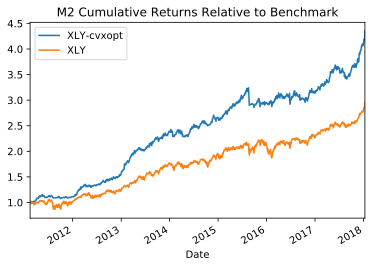

In [13]:
# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark")
s_etf.plot(ax=ax, legend='right')

In [ ]:
# Create Chart to show return spread vs. ETF for a given time window
# Conclusion: The shorter the holding gets the more likely to underperform
holding = 180; stop = int(len(alloc) - holding); jumps = 10
offsets = [x for x in range(0, stop, jumps)]

msg = "Portfolio metrics starting every {} trading days and holding for {} days"
print(msg.format(jumps, holding))

cols = ["M2", "Bechmark", "M2_Return", "M2_StdDev", "M2_Sharpe"]
results = pd.DataFrame([], index=offsets, columns=cols)
for o in offsets:
    start = np.min([o, len(alloc)-1])
    end = np.min([o+holding, len(alloc)])
    p = px_portion[start:end].copy()
    s_etf = (spyder_etf[-len(px_portion):][start:end].pct_change() + 1).prod()
    r, w = get_weights(p, "W-WED", max_w=0.10)
    port_perf = calc_port_performance(r.values, w.values)
    pdf = pd.DataFrame(port_perf, index=r.index) # index by date
    ret, std, sharpe = portfolio_metrics(pdf)
    results.loc[o, cols]= [pdf[-1:].values[0][0], s_etf, ret, std, sharpe]
chart_title = "Cumulative Return Starting every {} days for {}".format(jumps, dwld_key)
results[cols[0:2]].plot(title=chart_title)
under = results[results["M2"] < results["Bechmark"]][results.columns[0]].count()
print("Portfolio underperformed: {}% of the time".format(under/len(results)*100))

In [16]:
# show portfolio metrics for a given time window
log = True
length = 252
msg = "Portfolio metrics for the last {} days"
print(msg.format(length))
w = alloc[-length:].astype(np.float)
r = returns[-length:].astype(np.float)
port_perf = calc_port_performance(r.values, w.values)
pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
portfolio_metrics(pdf);

Portfolio metrics for the last 252 days
Ann. return: 31.60%, std dev: 10.53%, sharpe: 3.00


2011 1.0957
2012 1.3945
2013 1.5234
2014 1.0947
2015 1.0908
2016 1.0322
2017 1.2812


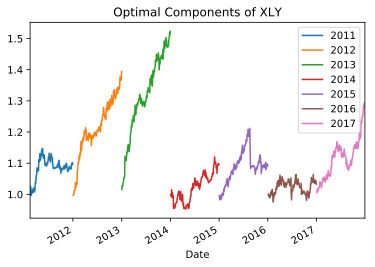

In [47]:
# plot portfolio performance by year
first_year = int(alloc.index[0].year)
last_year = int(alloc.index[-1].year)
years = [y for y in range(first_year, last_year, 1)] 

def perf_by_years(r, a, years):
    ax = plt.axes()
    for y in years:
        year = str(y)
        w = alloc.loc[year].astype(np.float16)
        r = returns.loc[year].astype(np.float16)
        p_perf = calc_port_performance(r.values, w.values)
        result = pd.DataFrame(p_perf, index=w.index, columns=[year])
        result.plot(title='Optimal Components of ' + dwld_key, ax=ax, legend='right')
        if log: print(year, result[-1:].values[0][0])

perf_by_years(returns, alloc, years)

In [25]:
#intervals[-1:]
w = alloc[-length:].astype(np.float16)
intervals = pd.to_datetime(date_intervals(r, frequency).index.tolist())
irange = intervals[-1:]
w = w.loc[irange].sum(axis=0).sort_values(ascending=False)
w[w > 0]
#(w[w > 0] / max_w)[:10].astype(np.int)

TIF     0.099976
NFLX    0.099976
MAR     0.099976
LOW     0.099976
TGT     0.099976
TSCO    0.099976
DRI     0.099182
HBI     0.052246
TPR     0.045807
EXPE    0.042023
IPG     0.041870
BBY     0.032959
GT      0.027039
LEN     0.026505
FOX     0.016678
KSS     0.015686
dtype: float16

In [23]:
# show top holdings and last recomended holding set

def recomend_allocs(w, irange):
    w = w.loc[irange].sum(axis=0).sort_values(ascending=False)
    return w[w > 0]

def frequent_allocs_periods(w, irange):
    w = (recomend_allocs(w, irange) / max_w).astype(np.int)
    return w

length = 252
w = alloc[-length:].astype(np.float16)
intervals = pd.to_datetime(date_intervals(r, frequency).index.tolist())

top = 10
irange = intervals
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(recomend_allocs(w, irange)[:top])

irange = intervals[-5:]
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(recomend_allocs(w, irange)[:top])

irange = intervals[-1:]
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(recomend_allocs(w, irange)[:top])

Top 10 holdings during the last 53 intervals
MCD     2.232422
AMZN    2.080078
WYNN    1.732422
DHI     1.541992
MAR     1.312500
NFLX    1.279297
PHM     1.267578
YUM     1.244141
PCLN    1.199219
TIF     1.155273
dtype: float16
Top 10 holdings during the last 5 intervals
FOX     0.416504
WYNN    0.399902
DRI     0.398926
TIF     0.377930
TSCO    0.361816
BBY     0.329834
HRB     0.251465
TPR     0.215698
MAR     0.211182
NFLX    0.199951
dtype: float16
Top 10 holdings during the last 1 intervals
TIF     0.099976
NFLX    0.099976
MAR     0.099976
LOW     0.099976
TGT     0.099976
TSCO    0.099976
DRI     0.099182
HBI     0.052246
TPR     0.045807
EXPE    0.042023
dtype: float16


#### Sensitivities

In [ ]:
lbs = [x for x in range(5, 15, 5)]
mws = (np.array([x for x in range(4, 24, 4)]) / 100).tolist()
for i, l in enumerate(lbs):
    for j, w in enumerate(mws):
        print(l, w)

In [ ]:
def create_matrix(px, start, end, step):
    print("Creating Sensitivity Matrix...")
    lbs = [x for x in range(start, end, step)]
    mws = (np.array([x for x in range(start, end, step)]) / 100).tolist()
    df = pd.DataFrame([], index=mws, columns=lbs)
    df.index.name = "Max Exposure"
    df.columns.name = "Lookback"
    
    for i, l in enumerate(lbs):
        for j, w in enumerate(mws):
            r, w = get_weights(px_portion, freq, lb=l, max_w=w)
            port_perf = calc_port_performance(r.values, w.values)
            pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
            days = len(pdf)
            ret, std, sharpe = portfolio_metrics(pdf);
            df.iloc[i, j] = (
                ret.astype(np.float16), 
                std.astype(np.float16), 
                sharpe.astype(np.float16))
    print("Complete")
    return df
def heatmap(df, cmap = plt.cm.inferno): 
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels( list(df.index))
    plt.colorbar(axim)

In [ ]:
sm = create_matrix(px, 10, 20, 5)

In [ ]:
curr = 2
m_list = ["Return", "StdDev", "Sharpe"]
print("Showing:", m_list[curr])
extract = lambda x: x[curr]
df = sm.applymap(extract)
heatmap(df.astype(float), cmap = plt.cm.gray_r)

In [ ]:
sm

#### Old Cells

In [ ]:
# Downloads pricing from yahoo for components + sector ETF
tickers = sector_tickers_map[dwld_key] # for individual components
#tickers = ticker_map["sectors"] # for individual ETFs
px = get_pricing(dwld_key + '-hold-pricing.csv', tickers, start_date.strftime(date_fmt))
etf = get_pricing(dwld_key + '.csv', dwld_key, start_date.strftime(date_fmt))
spyder_etf = pd.DataFrame(etf)
spyder_etf.index.name = "Date"
spyder_etf.columns=[dwld_key]
spyder_etf.to_csv(dwld_key + '.csv')

In [ ]:
#CHECK compounding math
#what were the top 10 allocations tickers?
top_stocks = alloc.sum(axis=0).sort_values(ascending=False)[:10].index.tolist()
# what was their allocation?
alloc = alloc[top_stocks]
# how much did we allocate to them?
cum_alloc = alloc.sum(axis=1)
# multiply the daily returns of top allocations times our allocation
port_return = (returns[top_stocks] * alloc).sum(axis=1)
# we add 1 to get the compounding index
port_index = (port_return + 1).cumprod()
#cumulative return for the portfolio
print(port_index[-1:], len(port_index), "days")

port_perf = calc_port_performance(returns[top_stocks].values, alloc.values)
print(port_perf[-1:], len(port_perf), "days")
print("annual return", pd.Series(port_perf).pct_change().mean() * 252)

In [ ]:
# show behaviour during sepcific time window
start = '1-1-2017'; days = 15
end = datetime.strptime(start, date_fmt) + timedelta(days)
window = pdf.loc['2017-1-31':'2017-9-30']
portfolio_metrics(window)

In [ ]:
for s in sector_tickers_map.keys():
    print(len(sector_tickers_map[s]))
    
#test both the portfolio performance using date intervals with optimization
df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_allocations = pd.DataFrame(np.zeros((len(intervals),cols)), index=pd.to_datetime(intervals))

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(mean_returns, cov_matrix)
    hist_allocations.loc[i.date()] = weights

port_perf = calc_port_performance(df.loc[intervals].values, hist_allocations.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

#### Test Methods

In [ ]:
d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))

df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
(df+1).cumprod().mean(axis=1).plot()

In [ ]:
#test both the portfolio performance using date intervals without optimization / equal weights
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    #lb_returns = df.loc[:i.date()].tail(lookback)
    weights = np.array([1/cols for _ in range(cols)])
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')

port_perf = calc_port_performance(df.values, hist_alloc.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
#test both the portfolio performance using date intervals with optimization
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(n, mean_returns, cov_matrix, min_w=0.0, max_w=0.3)
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
hist_alloc

port_perf = calc_port_performance(df.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf)
pdf.plot()
port_perf[-1:]

In [ ]:
px = get_pricing(ticker_map[key], '01/01/2017')
returns = px.sort_index().pct_change()
compound(returns).plot()

In [ ]:
w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(returns)

ann_returns = np.dot((mean_returns * 252), weights)
ann_stdev = np.sqrt(252/len(returns)) * std_dev
print(weights.shape, cov_matrix.shape)
port_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
print("eq weight return(exp)", ann_returns)
print("port risk(exp):", port_variance)
print("sharpe ratio:", ann_returns / port_variance)

In [ ]:
# Long only portfolio optimization.
weights = get_mvo_allocations(mean_returns, cov_matrix)
np_weights = np.array([weights]).T
exp_return = np.dot(np.array([mean_daily_returns.values]), np_weights) * 252
portfolio_std_dev = np.sqrt(np.dot(np_weights.T, np.dot(cov_matrix, np_weights))) * np.sqrt(252)
print("optimized return(exp):", exp_return)
print("optimized portfolio risk(exp):", portfolio_std_dev)
print("sharpe ratio:", exp_return / portfolio_std_dev)

In [ ]:
# Compute trade-off curve.
SAMPLES = 100
weights = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    weights.append([i[0] for i in w.value.tolist()])
    risk_data[i] = cvx.sqrt(risk).value
    ret_data[i] = ret.value
print('Optimization status:', prob.status)
#w.value, risk_data, ret_data
#ret_data / risk_data # sharpe ratio
#risk_data[np.argmin(risk_data)], risk_data[np.argmax(ret_data)]
#wgt_cum_ret = (ret_data + 1).cumprod()
cols = returns.columns.tolist();
allocs = show_weights(weights, returns.columns, ret_data, risk_data); allocs.tail()
allocs[cols].plot()
print(allocs[-1:].apply(two_dec))

In [ ]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = range(1, 100, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker], ret_data[marker]))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    ax.annotate(returns.columns[i], xy=(sqrt(Sigma[i,i]).value, mu[i]))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
gamma_vals.shape, risk_data.shape, ret_data.shape
summary = pd.DataFrame([], columns=['gamma', 'risk', 'return'], index=range(SAMPLES))
summary['gamma'] = np.array([gamma_vals]).T
summary['risk'] = np.array([risk_data]).T
summary['return'] = np.array([ret_data]).T
summary[['risk','return']].plot(kind='line')

In [ ]:
numdays, cols = 252, 10

np.random.seed(42)
numdays, cols = 100, 10
end_date_str, tgt_date_str = '12-31-2017', '12-27-2017'
freq = 7; lookback = 20

arr = (np.random.rand(numdays, cols) - 0.5) / 10
weights = np.random.rand(1, cols)
weights = weights / np.sum(weights, axis=1).T

In [ ]:
#test the portfolio performance calculation
port_perf = calc_port_performance(arr, weights)
#pd.DataFrame(port_perf).plot()
port_perf

In [ ]:
#test the date rules / intervals
end_date = datetime.strptime(end_date_str, date_fmt)
d_rng = sorted([end_date - timedelta(x) for x in range(0, numdays)]) # using list comprenhensions
sorted(date_rules(d_rng, tgt_date_str, freq))

d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))
intervals = list(sorted(date_rules(d_rng, tgt_date_str, freq)))
print("check:", len(intervals), "equals", numdays // freq, "result:",len(intervals) == numdays // freq) # check if intervals works
intervals[-5:]